# Reconocimiento de dígitos con KNN



Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: build: File exists
-- The C compiler identification is AppleClang 10.0.0.10001044
-- The CXX compiler identification is AppleClang 10.0.0.10001044
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /opt/anaconda3/bin/python3 (found version "3.7.6") 
-- Found PythonLibs: /opt/anaconda3/lib/libpython3.7m.dylib
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing

In [13]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/Users/celeste/facultad/metodos/metnum-tp2/notebooks
Python 3.7.6


## Explorando los datos

In [14]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

df_train = pd.read_csv("../data/train.csv")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
#n_begin = 10000
#n_end = 10000
#n_step = 1

#fold_begin = 5
#fold_end = 5
#fold_step = 1

n = 10000
K = 5

neigh_begin = 3
neigh_end = 7
neigh_step = 2

alpha_begin = 20
alpha_end = 80
alpha_step = 10

alpha_max = 200

PCA_FLAG = True

if (not PCA_FLAG):
    alpha_begin = 1
    alpha_end = 1
    alpha_step = 1

In [16]:
#ns = range(n_begin, n_end+1, n_step)
#Ks = range(fold_begin, fold_end+1, fold_step)
ks = [1]
alphas = [31]
samples = [1000, 3000, 5000, 15000, 25000, 35000, 42000]

Es un csv, con columnas por cada pixel

### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [17]:
df_train = df_train.sample(frac=1)
df_train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
182,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22223,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38278,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27935,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28201,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12381,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9794,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41168,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32945,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [8]:
# Uso values para mandar todo a arrays de numpy

X = c[c.columns[1:]].values
y = c["label"].values.reshape(-1, 1)

X.shape, y.shape


((10000, 784), (10000, 1))

### Conjunto de development

In [18]:
import metnum
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold
import time
from IPython.display import Javascript

In [19]:
def do_pca(alpha, X_train, X_validate):
    pca = metnum.PCA(alpha)
    pca.fit(X_train)
    X_train_transformed = pca.transform(X_train)
    X_validate_transformed = pca.transform(X_validate)
    return X_train_transformed, X_validate_transformed

In [20]:
def do_knn(k, X_train, y_train, X_predict):
    start = time.time()
    knn = metnum.KNNClassifier(k)
    knn.fit(X_train, y_train)
    y_predicted = knn.predict(X_predict)
    stop = time.time()
    
    return y_predicted, (stop-start)/60

In [22]:
# vamos guardando las metricas en dataframes
## las filas representan los ks y las columnas representan los alfas
accuracy_score_means = pd.DataFrame(np.zeros((len(ks), len(samples))), index=ks, columns=samples)
precision_score_means = accuracy_score_means.copy()
recall_score_means = accuracy_score_means.copy()

accuracy_score_stds = accuracy_score_means.copy()
precision_score_stds = accuracy_score_means.copy()
recall_score_stds = accuracy_score_means.copy()

times = accuracy_score_means.copy()

In [ ]:
%%time
## hacemos kNN / kNN+PCA
for k,alpha in zip(ks, alphas):
    for sample_size in samples:
        c = df_train[:sample_size]
        X = c[c.columns[1:]].values
        y = c["label"].values.reshape(-1, 1)
        ac_scores = np.empty(0, dtype='d')
        rc_scores = np.empty(0, dtype='d')
        pc_scores = np.empty(0, dtype='d')
        tms = np.empty(0, dtype='d')

        folds = StratifiedKFold(n_splits=K)    
        for train_index, validate_index in folds.split(X, y.flatten()):
            X_train, X_validate = X[train_index], X[validate_index]
            y_train, y_validate = y[train_index], y[validate_index]
            if (PCA_FLAG):
                X_train, X_validate = do_pca(alpha, X_train, X_validate)
                y_predicted, exec_time = do_knn(k, X_train, y_train, X_validate)

            ac_score = accuracy_score(y_validate, y_predicted)
            rc_score = recall_score(y_validate, y_predicted, labels = [0,1,2,3,4,5,6,7,8,9], average='macro')
            pc_score = precision_score(y_validate, y_predicted, labels = [0,1,2,3,4,5,6,7,8,9], average='macro')

            ac_scores = np.append(ac_scores, ac_score)
            rc_scores = np.append(rc_scores, rc_score)
            pc_scores = np.append(pc_scores, pc_score)
            tms = np.append(tms, exec_time)
        accuracy_score_means.loc[k, sample_size] = np.mean(ac_scores)
        recall_score_means.loc[k, sample_size] = np.mean(rc_scores)
        precision_score_means.loc[k, sample_size] = np.mean(pc_scores)

        accuracy_score_stds.loc[k, sample_size] = np.std(ac_scores)
        recall_score_stds.loc[k, sample_size] = np.std(rc_scores)
        precision_score_stds.loc[k, sample_size] = np.std(pc_scores)

        times.loc[k, sample_size] = np.sum(tms)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedM

In [24]:
Javascript("new Notification('Termino de correr kNN/kNN+PCA')")

<IPython.core.display.Javascript object>

In [25]:
# guardamos las metricas en csvs
import subprocess

exp_desc = "n{}_K{}_k{}-{}-{}_alfa{}-{}-{}".format(n, K, neigh_begin, neigh_end, neigh_step, alpha_begin, alpha_end, alpha_step)
dirname = exp_desc

proc_res = subprocess.run(['mkdir', dirname], stdout=subprocess.PIPE)
assert proc_res.returncode == 0 # si el dir ya existe, no pisamos nada!

accuracy_score_means.to_csv("{}/ac_means.csv".format(dirname))
recall_score_means.to_csv("{}/rc_means.csv".format(dirname))
precision_score_means.to_csv("{}/pc_means.csv".format(dirname))
accuracy_score_stds.to_csv("{}/ac_stds.csv".format(dirname))
recall_score_stds.to_csv("{}/rc_stds.csv".format(dirname))
precision_score_stds.to_csv("{}/pc_stds.csv".format(dirname))
times.to_csv("{}/times.csv".format(dirname))
Javascript("new Notification('Se guardaron las metricas exitosamente')")

<IPython.core.display.Javascript object>

# Prueben si les anda Seaborn, es re facil hacer heatmaps
### A mi solo me anda desde jupyter notebook, no se por que

In [ ]:
#import seaborn as sns

In [ ]:
#sns.heatmap(accuracy_score_means)

In [ ]:
#sns.heatmap(recall_score_means)

In [ ]:
#sns.heatmap(precision_score_means)

In [ ]:
#sns.heatmap(times)

# Adapte los primeros graficos

In [11]:
import matplotlib.pyplot as plt

In [26]:
alpha_grafico = alphas[0]
plt.plot(ks, accuracy_score_means.loc[:,alpha_grafico], color='green', marker='o', linestyle='dashed',linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('k')
plt.title("Para alfa={} fijo".format(alpha_grafico))
plt.grid()
#plt.savefig("{}/accuracy_ks_alfa-fijo-{}.png".format(dirname, alpha_grafico))

KeyError: 34

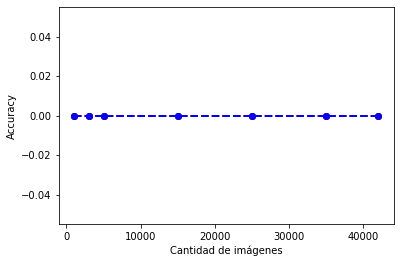

In [28]:
colors =['green', 'violet', 'red', 'blue']
for k_grafico, colour in zip(ks,colors):
    plt.plot(samples, accuracy_score_means.loc[k_grafico,:], color=colour, marker='o', linestyle='dashed',linewidth=2)
    plt.ylabel('Accuracy')
    plt.xlabel('Cantidad de imágenes')
    #plt.title("Accuracy para kNN+PCA con k={} fijo".format(k_grafico))
    plt.grid()
    plt.savefig("{}/accuracy_alfas_k-fijo-{}.png".format(dirname, k_grafico))

# Estos de abajo todavia no, no van a andar

In [ ]:
plt.plot(ks_m, ac_m, color='green', marker='o', linestyle='dashed',linewidth=2)
plt.ylabel('Accuracy')
plt.xlabel('Alpha para Knn con k=5')
plt.savefig('10000accuracyAlphaK5.png')

In [ ]:
plt.plot(ks_m, rc_m, color='red', marker='o', linestyle='dashed',linewidth=2)
plt.ylabel('Recall')
plt.xlabel('Alpha para Knn con k=5')
plt.savefig('10000recallAlphaK5.png')

In [ ]:
plt.plot(ks_m, tm_m, color='blue', marker='o', linestyle='dashed',linewidth=2)
plt.ylabel('Time')
plt.xlabel('Alpha para Knn con k=5')
plt.savefig('10000timeAlphaK5.png')

In [ ]:
plt.plot(ks_m, pc_m, color='violet', marker='o', linestyle='dashed',linewidth=2)
plt.ylabel('Precision')
plt.xlabel('Alpha para Knn con k=5')
plt.savefig('10000precisionAlphaK5.png')